## Семинар 2 "Распознавание рукописных цифр"

ФИО: Косенков Дмитрий Валерьевич 
ML-22

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [59]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [60]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [61]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

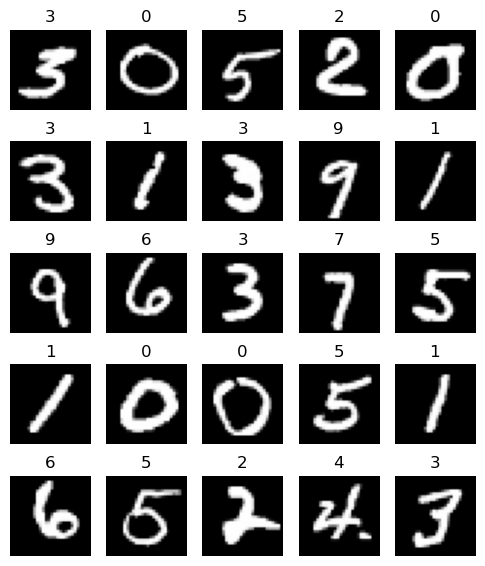

In [62]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [63]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [64]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.311/0.305	Accuracy: 0.919/0.921

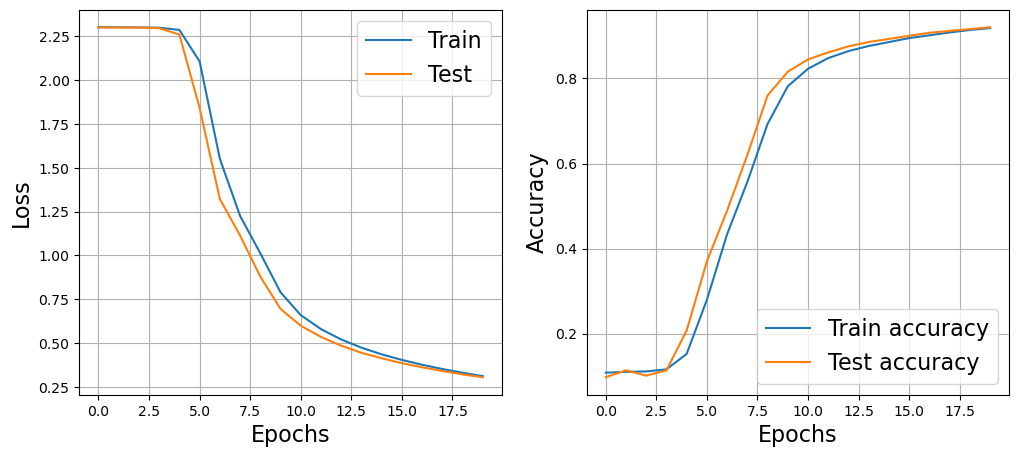

In [65]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [66]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [67]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [68]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.081	Accuracy: 0.991/0.977

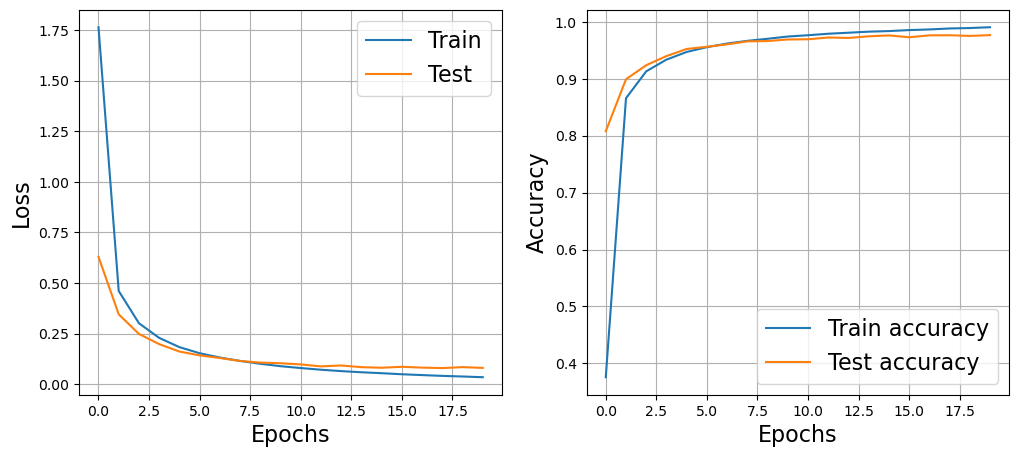

In [69]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.082	Accuracy: 0.987/0.976

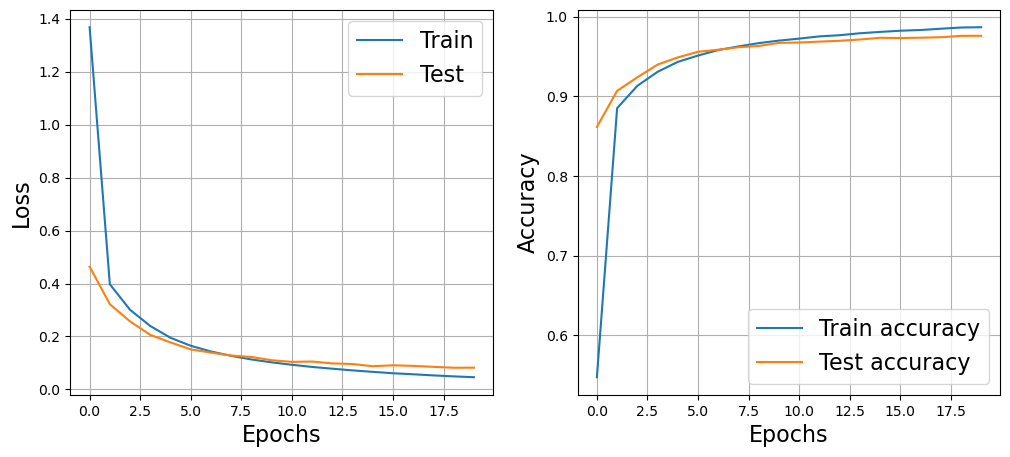

In [70]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### HW1 (1 балл): Реализовать Tanh

In [71]:
class Tanh:
    '''
    Tanh(x) = 2/(1+e^-2x) - 1
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return 2 / ( 1 + np.exp(-2*X)) - 1
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        tan = 2 / ( 1 + np.exp(-2*X)) - 1
        dydX = 1- tan*tan
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.075	Accuracy: 0.994/0.978

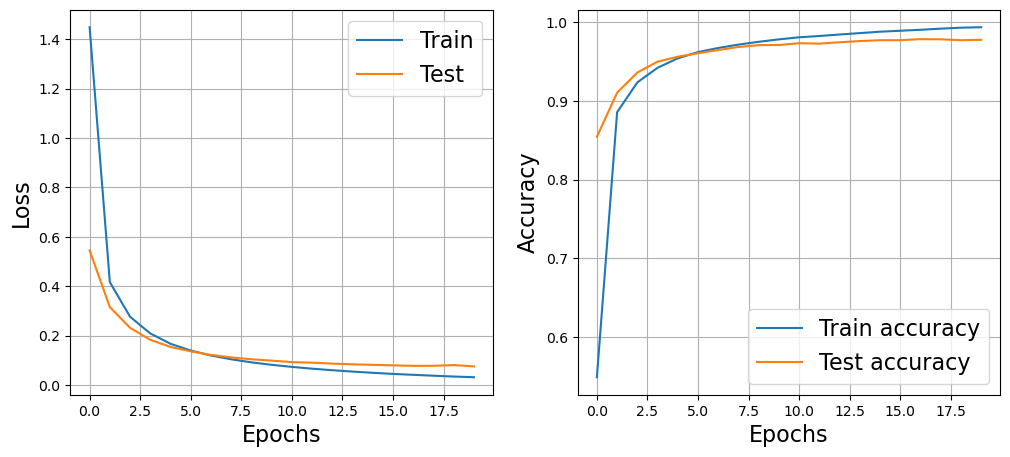

In [72]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

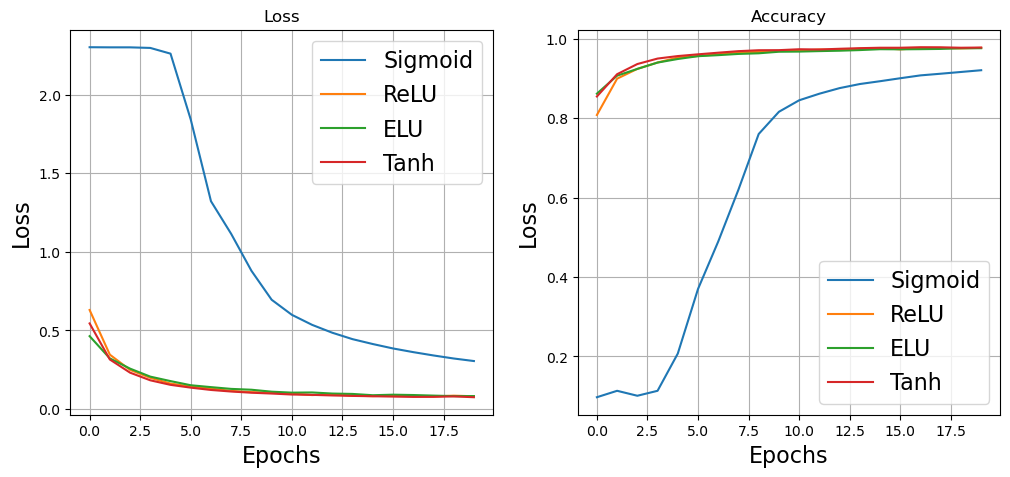

In [73]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [74]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

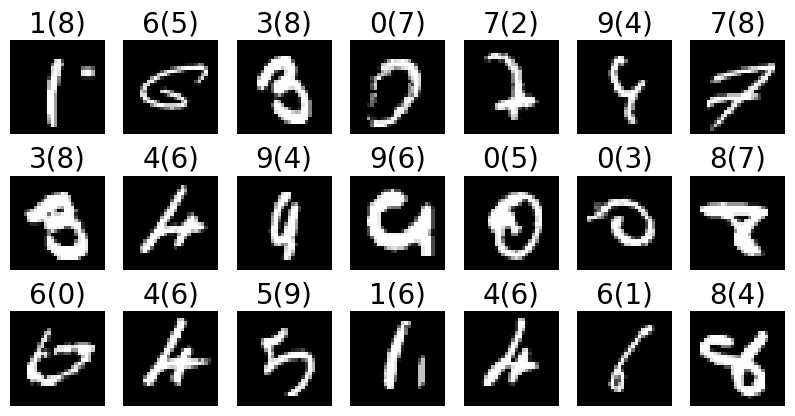

In [75]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [76]:
from skimage.transform import rotate,warp
from skimage.util import random_noise
from skimage.transform import SimilarityTransform

Поворот

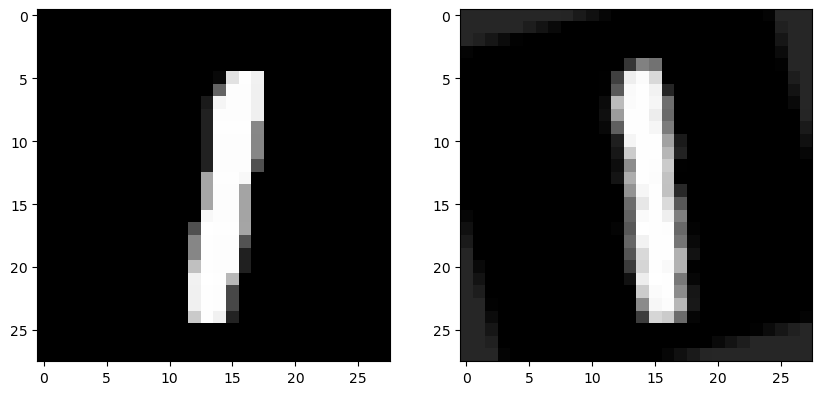

In [77]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.subplot(1, 2, 2)
plt.imshow(rotate(X[0].reshape(28, 28),15), cmap=plt.cm.Greys_r)

Случайные сдвиги

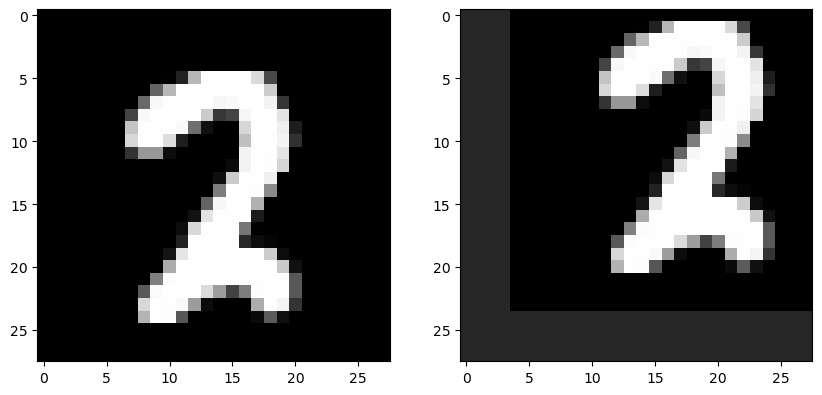

In [78]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[1].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.subplot(1, 2, 2)
tform = SimilarityTransform(translation=(np.random.randint(-10,10), np.random.randint(-8,8)))
plt.imshow(warp(X[1].reshape(28, 28),tform), cmap=plt.cm.Greys_r)

Случайный шум

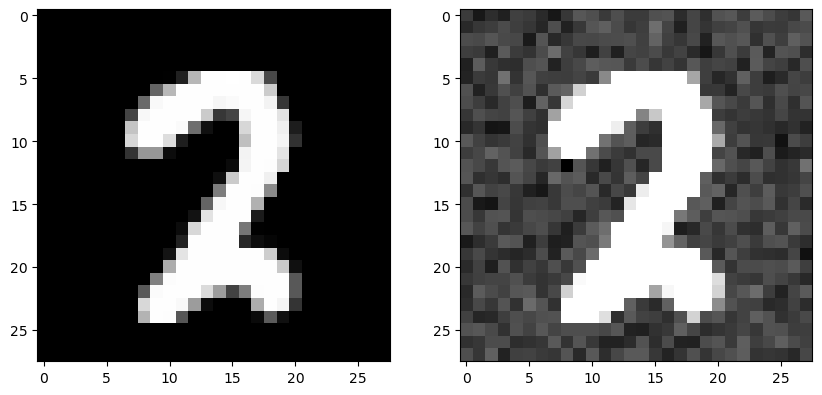

In [79]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[1].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.subplot(1, 2, 2)
plt.imshow(random_noise(X[1].reshape(28, 28)), cmap=plt.cm.Greys_r)

In [80]:
def shift_image(image):
    X = image.numpy()
    tform = SimilarityTransform(translation=(np.random.randint(-8,8), np.random.randint(-8,8)))
    return warp(X.reshape(28,28),tform)

def rotate_image(image):
    X = image.numpy()
    rotated = rotate(X.reshape(28, 28), np.random.randint(-15,15))
    return rotated

def noize_image(image):
    X = image.numpy()
    return random_noise(X.reshape(28, 28))
def all_image(image):
    
    return noize_image(shift_image(rotate(image)))

class ShiftTransform:
    def __call__(self, image):
        aug_image = shift_image(image)  
        return transforms.ToTensor()(aug_image)  
class RotateTransform:
    def __call__(self, image):
        aug_image = rotate_image(image)  
        return transforms.ToTensor()(aug_image) 
class AllTransform:
    def __call__(self, image):
        aug_image = all_image(image) 
        return transforms.ToTensor()(aug_image)  
class NoizeTransform:
    def __call__(self, image):
        aug_image = noize_image(image) 
        return transforms.ToTensor()(aug_image)  

In [81]:
def createNetwork():
    network = NeuralNetwork([Linear(784, 100), ELU(),
                Linear(100, 100), Tanh(),
                Linear(100, 10)])
    return network

In [82]:
def start(transf):
   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
   train_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transf,
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
   train_dataset = MNIST('.', train = True, download = True, transform = train_transform)
   test_dataset = MNIST('.', train = False, transform = transform)

   train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
   test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
   return train(createNetwork(), 20, 0.01, plot=True, verbose=True)

In [83]:
own_transforms = [ShiftTransform, RotateTransform, NoizeTransform,AllTransform]

Epoch 19... (Train/Test) NLL: 0.050/0.079	Accuracy: 0.987/0.976

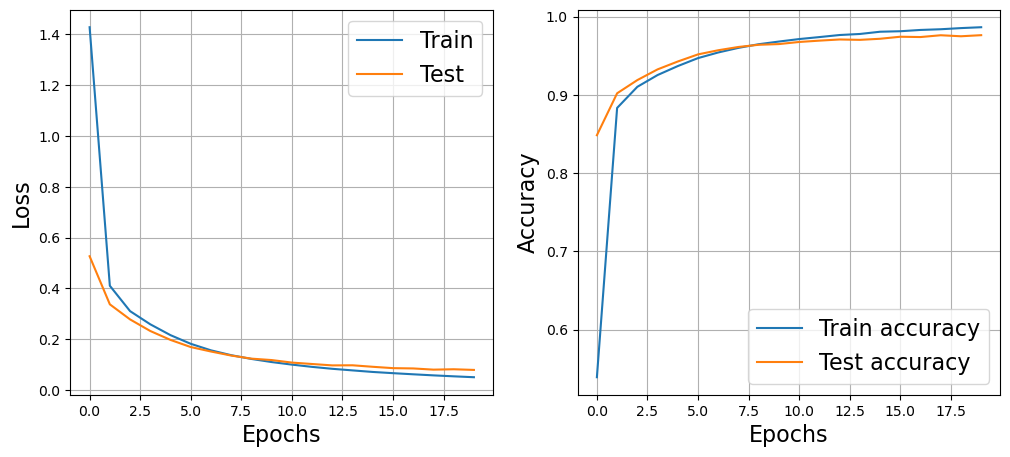

In [84]:
tr_t = list()
ts_t=list()
tr_ac_t=list()
ts_ac_t=list()
for t in own_transforms:
    t1, t2, t3, t4 = start(t)
    tr_t.append(t1), ts_t.append(t2), tr_ac_t.append(t3), ts_ac_t.append(t4)

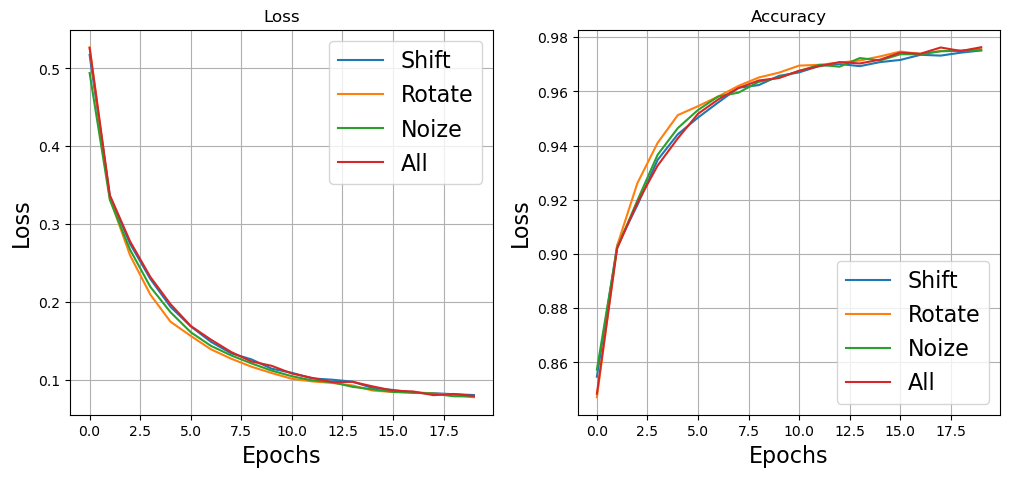

In [88]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_t[0], label='Shift')
plt.plot(ts_t[1], label='Rotate')
plt.plot(ts_t[2], label='Noize')
plt.plot(ts_t[3], label='All')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_t[0], label='Shift')
plt.plot(ts_ac_t[1], label='Rotate')
plt.plot(ts_ac_t[2], label='Noize')
plt.plot(ts_ac_t[3], label='All')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [86]:
for x in zip([ShiftTransform.__name__, RotateTransform.__name__, NoizeTransform.__name__,AllTransform.__name__],ts_ac_t):
    print(f'{x[0]} {x[1][-1]}')

ShiftTransform 0.9751397763578274
RotateTransform 0.9757388178913738
NoizeTransform 0.9752396166134185
AllTransform 0.9763378594249201


In [87]:
ShiftTransform.__name__

'ShiftTransform'

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

 1) Выбор нелинейности сильно влияет на обучаемость модели. Сигмоида сходится медленно и дает неточные результаты, что возможно объясняется затуханием градиента. Но зато она меньше всех поддвержена переобучению
 2) Relu и Elu показали средние результаты. Скорее всего из-за простоты производной они быстрее считаются и сходятся. Но они (Elu несильно) зануляют отрицательные входные значения, из-за чего теряют  в точности.
 3) Аугментации возможно помогают улучшить результат, но несильно. Лучшего эффекта удалось достичь при одновременном использовании шума, поворотов и сдвига.